In [2]:
pip install segyio

In [3]:
pip install lasio


In [4]:
import segyio
import pandas as pd
import numpy as np
import os
import lasio


In [5]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/2024_Geohackathon')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!ls

 2024_geohackathon.ipynb   LONCCARICA-1.las	        RMSAmplitude.sgy    VIROVITICA-3ALFA.las
 frequency.sgy		   Preprocessing.ipynb	        SUHOPOLJE-1.las
'Instantanous Phase.sgy'   REZOVACCKE_KRCCEVINE-1.las   unknown_wells.csv
 known_wells.csv	   REZOVACCKE_KRCCEVINE-2.las   VIROVITICA-1.las


In [7]:
# Define the path to your .las files
data_path = "/content/drive/My Drive/2024_Geohackathon/"
las_files = [file for file in os.listdir(data_path) if file.endswith(".las")]

# Initialize a dictionary to store well data
well_data = {}

# Read each .las file
for file in las_files:
    file_path = os.path.join(data_path, file)
    las = lasio.read(file_path)

    # Extract the well name (or use file name)
    well_name = file.split(".")[0]

    # Convert .las data to a DataFrame
    df = las.df()
    df["Depth"] = las.index  # Add depth as a column

    # Store the DataFrame in the dictionary
    well_data[well_name] = df

# Create a summary of available logs
summary = {well: ", ".join(data.columns) for well, data in well_data.items()}  # Join columns as a string
summary_df = pd.DataFrame(list(summary.items()), columns=["Well Name", "Available Logs"])

# Display the summary DataFrame
summary_df

,Well Name,Available Logs
0,REZOVACCKE_KRCCEVINE-1,"AC, CALI, NPHI, RHOB, GR, R64, TEMP, R16, SP, ..."
1,REZOVACCKE_KRCCEVINE-2,"NPHI, RHOB, GR, CALI, SP, AC, RDEEP, RSHALLOW,..."
2,SUHOPOLJE-1,"AC, CALI, NPHI, RHOB, GR, RLML, RNML, SP, RDEE..."
3,VIROVITICA-1,"R64, TEMP, CALI, R16, SP, RDEEP, RLML, RNML, D..."
4,VIROVITICA-3ALFA,"AC, CALI, NPHI, RHOB, GR, PERM, PHIE, PHIT, SP..."
5,LONCCARICA-1,"CALI, TEMP, AC, SP, R16, R64, RLML, RNML, Depth"


In [8]:
# Initialize a dictionary to store well depths
well_depths = {}

# Loop through each well log file and extract depths
for file in las_files:
    well_name = file.split(".")[0]  # Extract well name from the filename
    las_file_path = os.path.join(data_path, file)

    try:
        # Read the LAS file
        las = lasio.read(las_file_path)

        # Extract the depth column (usually the first column in LAS files)
        depth = las.df().index.values  # Assuming the index of the LAS file contains the depths

        # Store the depth array in the dictionary
        well_depths[well_name] = depth
        print(f"Extracted depths for {well_name}: {len(depth)} entries")
    except Exception as e:
        print(f"Error reading {file}: {e}")

# Confirm the structure of well_depths
print("Well Depths Dictionary:")
for well, depth_array in well_depths.items():
    print(f"{well} - Depth Points: {len(depth_array)}")


Extracted depths for REZOVACCKE_KRCCEVINE-1: 33101 entries
Extracted depths for REZOVACCKE_KRCCEVINE-2: 45541 entries
Extracted depths for SUHOPOLJE-1: 47701 entries
Extracted depths for VIROVITICA-1: 28451 entries
Extracted depths for VIROVITICA-3ALFA: 38269 entries
Extracted depths for LONCCARICA-1: 17201 entries
Well Depths Dictionary:
REZOVACCKE_KRCCEVINE-1 - Depth Points: 33101
REZOVACCKE_KRCCEVINE-2 - Depth Points: 45541
SUHOPOLJE-1 - Depth Points: 47701
VIROVITICA-1 - Depth Points: 28451
VIROVITICA-3ALFA - Depth Points: 38269
LONCCARICA-1 - Depth Points: 17201


In [9]:
# read the seismic files
# Define the seismic files
seismic_files = {
    "frequency": "frequency.sgy",
    "phase": "Instantanous Phase.sgy",
    "amplitude": "RMSAmplitude.sgy"
}

# Initialize a dictionary to store seismic data
seismic_data = {}

for attribute_name, file_name in seismic_files.items():
    file_path = os.path.join(data_path, file_name)

    try:
        with segyio.open(file_path, "r", ignore_geometry=True) as segy:
            segy.mmap()  # Memory-map the SEGY file for fast access

            # Extract trace data
            traces = np.array([trace for trace in segy.trace[:]])

            # Extract depth or time values (samples)
            depth = segy.samples  # SEGY files often store depth or time in samples

            # Check if the extracted dimensions align
            if len(depth) != traces.shape[1]:
                print(f"Warning: Depth and trace dimensions mismatch for {file_name}")

            # Store in the dictionary
            seismic_data[attribute_name] = {
                "Depth": depth,
                "Traces": traces
            }

            # Print a summary of the file
            print(f"Successfully read {attribute_name}")
            print(f"Depth Range: {depth[0]} - {depth[-1]}")
            print(f"Number of Traces: {traces.shape[0]}")

    except Exception as e:
        print(f"Error reading {file_name}: {e}")



Successfully read frequency
Depth Range: 0.0 - 6490.0
Number of Traces: 1387
Successfully read phase
Depth Range: 0.0 - 6490.0
Number of Traces: 1387
Successfully read amplitude
Depth Range: 0.0 - 6490.0
Number of Traces: 1387


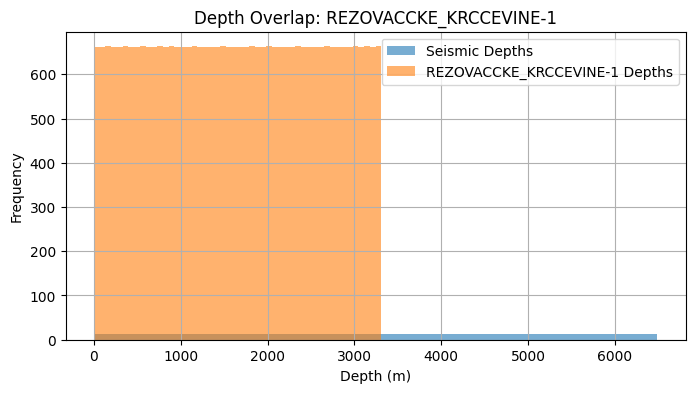

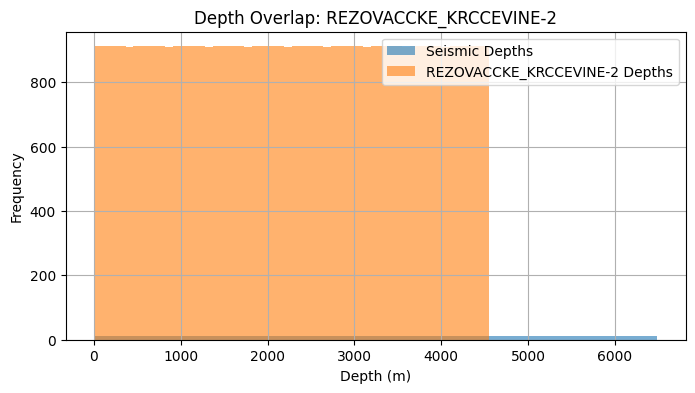

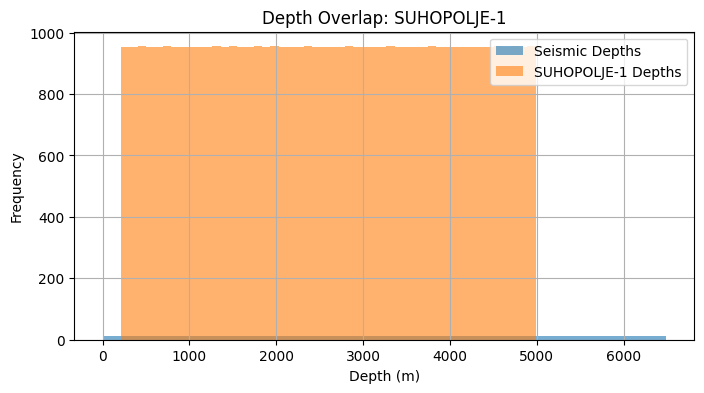

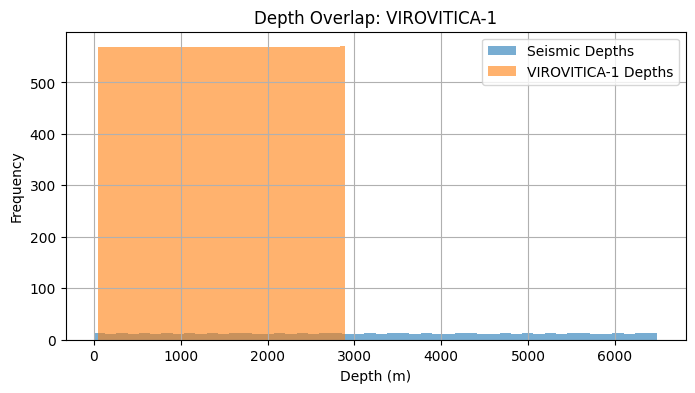

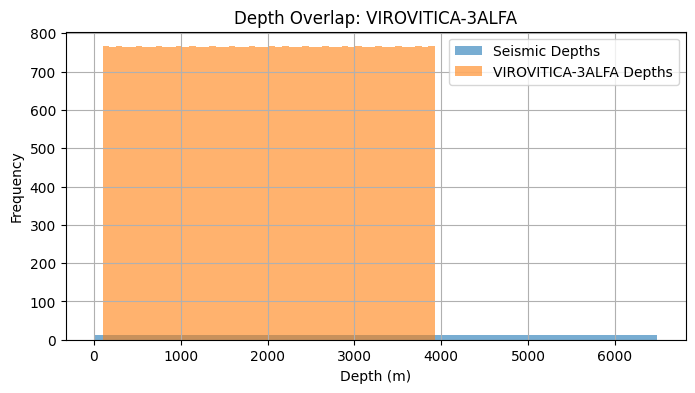

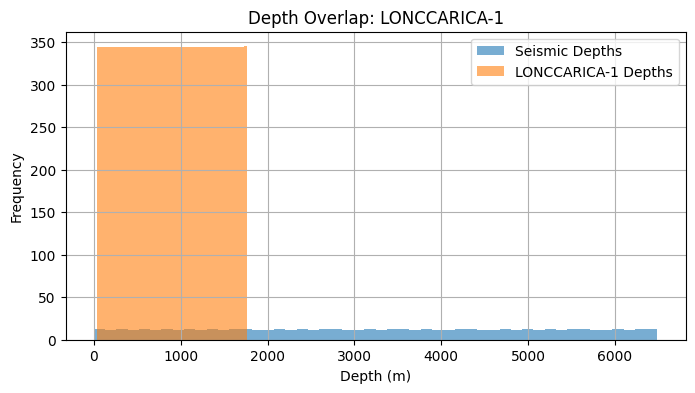

In [10]:
#plot the depth overlap

# Assuming you want to use the 'frequency' attribute for seismic depths:
seismic_depths = seismic_data['frequency']['Depth']

for well_name, well_depth_array in well_depths.items():
    plt.figure(figsize=(8, 4))
    plt.hist(seismic_depths, bins=50, alpha=0.6, label="Seismic Depths")
    plt.hist(well_depth_array, bins=50, alpha=0.6, label=f"{well_name} Depths")
    plt.title(f"Depth Overlap: {well_name}")
    plt.xlabel("Depth (m)")
    plt.ylabel("Frequency")
    plt.legend()
    plt.grid()
    plt.show()

In [11]:
from scipy.interpolate import interp1d

# Initialize a dictionary to store interpolated seismic data
interpolated_seismic_data = {}

for well_name, well_depth_array in well_depths.items():
    print(f"Processing {well_name} with {len(well_depth_array)} depth points...")

    # Filter for overlapping depth range
    overlap_indices = (seismic_depths >= well_depth_array.min()) & (seismic_depths <= well_depth_array.max())
    overlapping_seismic_depths = seismic_depths[overlap_indices]

    # Interpolate seismic attributes for the well
    interpolated_data = {}
    for attr_name, attr_values in seismic_data.items():
        interpolation_fn = interp1d(
            overlapping_seismic_depths,
            attr_values["Traces"][:, overlap_indices].mean(axis=0),
            bounds_error=False,
            fill_value=np.nan,
        )
        interpolated_data[attr_name] = interpolation_fn(well_depth_array)

    # Combine into a DataFrame
    df_interpolated = pd.DataFrame(interpolated_data, index=well_depth_array)
    df_interpolated.index.name = "Depth (m)"

    # Fill missing data
    df_interpolated = df_interpolated.fillna(method="ffill").fillna(method="bfill")

    # Store in the dictionary
    interpolated_seismic_data[well_name] = df_interpolated

    # Combine into a DataFrame
    df_interpolated = pd.DataFrame(interpolated_data, index=well_depth_array)
    df_interpolated.index.name = "Depth (m)"
    print(f"Interpolated seismic data for {well_name}:\n", df_interpolated.head())


Processing REZOVACCKE_KRCCEVINE-1 with 33101 depth points...
Interpolated seismic data for REZOVACCKE_KRCCEVINE-1:
            frequency  phase  amplitude
Depth (m)                             
0.0              0.0    0.0        0.0
0.1              0.0    0.0        0.0
0.2              0.0    0.0        0.0
0.3              0.0    0.0        0.0
0.4              0.0    0.0        0.0
Processing REZOVACCKE_KRCCEVINE-2 with 45541 depth points...
Interpolated seismic data for REZOVACCKE_KRCCEVINE-2:
            frequency  phase  amplitude
Depth (m)                             
1.0              NaN    NaN        NaN
1.1              NaN    NaN        NaN
1.2              NaN    NaN        NaN
1.3              NaN    NaN        NaN
1.4              NaN    NaN        NaN
Processing SUHOPOLJE-1 with 47701 depth points...
Interpolated seismic data for SUHOPOLJE-1:
            frequency  phase  amplitude
Depth (m)                             
215.0            NaN    NaN        NaN
215.1      

<ipython-input-11-e1782b43ae84>:29: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_interpolated = df_interpolated.fillna(method="ffill").fillna(method="bfill")
<ipython-input-11-e1782b43ae84>:29: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_interpolated = df_interpolated.fillna(method="ffill").fillna(method="bfill")
<ipython-input-11-e1782b43ae84>:29: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_interpolated = df_interpolated.fillna(method="ffill").fillna(method="bfill")
<ipython-input-11-e1782b43ae84>:29: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_interpolated = df_interpolated.fillna(method="ffill").fillna(

In [12]:
# Check for missing data percentages
for well_name, data in interpolated_seismic_data.items():
    missing_percentage = data.isnull().mean() * 100
    print(f"{well_name} - Missing Data Percentage:")
    print(missing_percentage)

REZOVACCKE_KRCCEVINE-1 - Missing Data Percentage:
frequency    0.0
phase        0.0
amplitude    0.0
dtype: float64
REZOVACCKE_KRCCEVINE-2 - Missing Data Percentage:
frequency    0.0
phase        0.0
amplitude    0.0
dtype: float64
SUHOPOLJE-1 - Missing Data Percentage:
frequency    0.0
phase        0.0
amplitude    0.0
dtype: float64
VIROVITICA-1 - Missing Data Percentage:
frequency    0.0
phase        0.0
amplitude    0.0
dtype: float64
VIROVITICA-3ALFA - Missing Data Percentage:
frequency    0.0
phase        0.0
amplitude    0.0
dtype: float64
LONCCARICA-1 - Missing Data Percentage:
frequency    0.0
phase        0.0
amplitude    0.0
dtype: float64


In [13]:
# check well depth and seismic depth ranges
for well_name, well_depth_array in well_depths.items():
    print(f"{well_name} - Well Depth Range: {well_depth_array.min()} to {well_depth_array.max()}")
    print(f"Seismic Depth Range: {seismic_depths.min()} to {seismic_depths.max()}")


REZOVACCKE_KRCCEVINE-1 - Well Depth Range: 0.0 to 3310.0
Seismic Depth Range: 0.0 to 6490.0
REZOVACCKE_KRCCEVINE-2 - Well Depth Range: 1.0 to 4555.0
Seismic Depth Range: 0.0 to 6490.0
SUHOPOLJE-1 - Well Depth Range: 215.0 to 4985.0
Seismic Depth Range: 0.0 to 6490.0
VIROVITICA-1 - Well Depth Range: 50.0 to 2895.0
Seismic Depth Range: 0.0 to 6490.0
VIROVITICA-3ALFA - Well Depth Range: 100.0 to 3926.8
Seismic Depth Range: 0.0 to 6490.0
LONCCARICA-1 - Well Depth Range: 40.0 to 1760.0
Seismic Depth Range: 0.0 to 6490.0


In [ ]:
# Fill NaN values with column-wise mean
#for well_name, data in interpolated_seismic_data.items():
#    interpolated_seismic_data[well_name] = data.fillna(data.mean())


In [14]:
for well_name, data in interpolated_seismic_data.items():
    print(f"{well_name} - Interpolated Data Statistics:")
    print(data.describe())


REZOVACCKE_KRCCEVINE-1 - Interpolated Data Statistics:
           frequency         phase     amplitude
count   33101.000000  33101.000000  33101.000000
mean    29343.199357      1.650865   3693.561289
std     21658.499090     87.853458   2646.225178
min         0.000000   -176.940078      0.000000
25%     14721.801289    -70.232589   1957.692437
50%     28323.807471      0.000000   3455.915771
75%     44520.108887     79.834886   5620.006606
max    108008.625253    178.447041  12385.705219
REZOVACCKE_KRCCEVINE-2 - Interpolated Data Statistics:
           frequency         phase     amplitude
count   45541.000000  45541.000000  45541.000000
mean    37577.737286      3.319446   4681.799215
std     25628.375301     88.435317   3070.681104
min         0.000000   -176.940078      0.000000
25%     17856.386514    -70.156700   2435.839234
50%     32516.196130      0.000000   4264.392875
75%     54995.551708     80.960241   6708.959139
max    109263.500963    178.447041  12753.207007
SUHOPOLJ

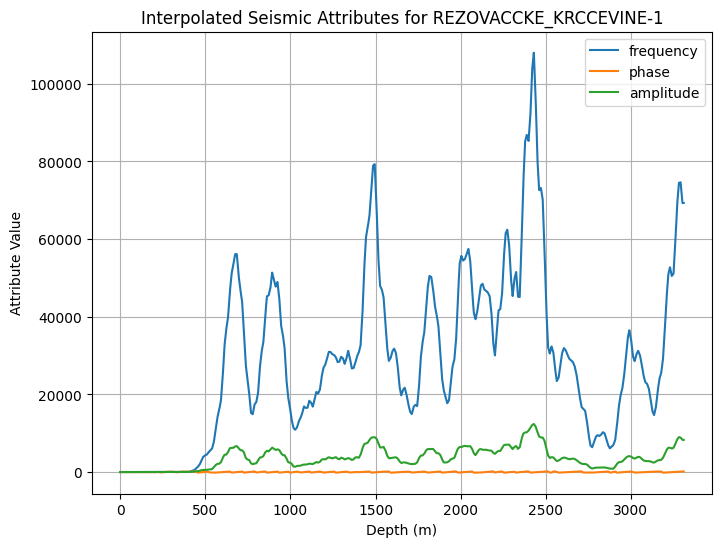

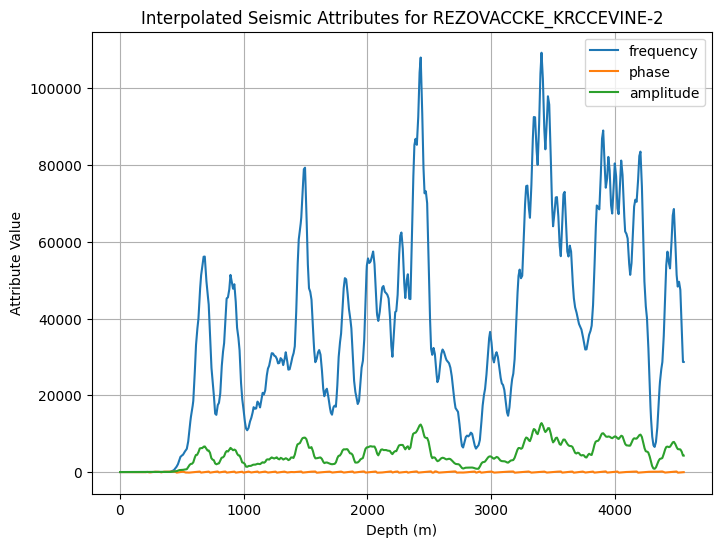

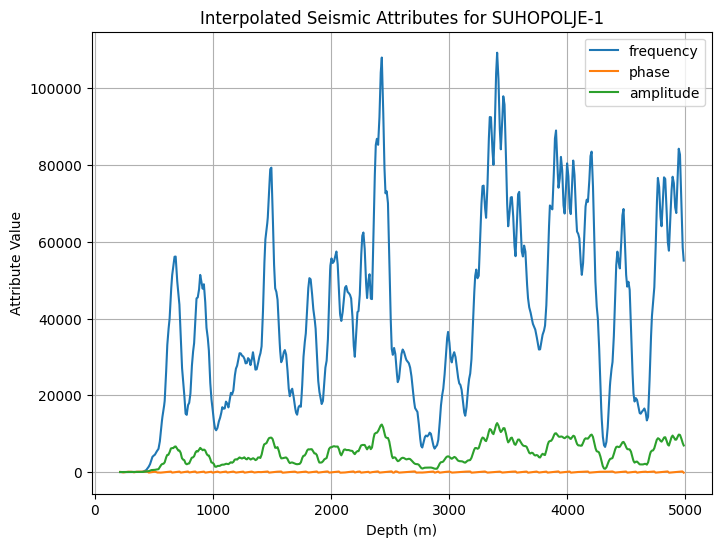

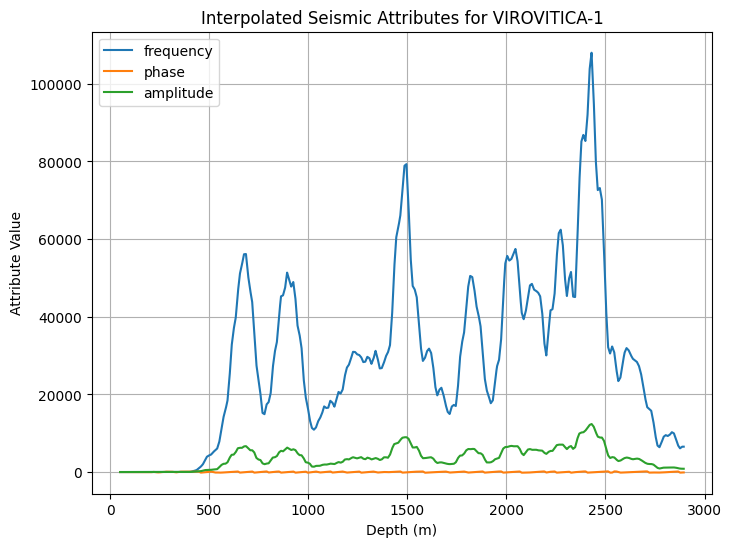

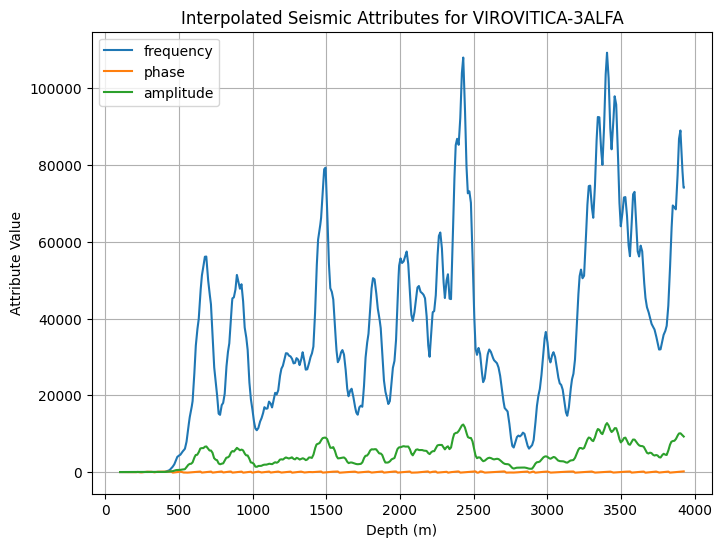

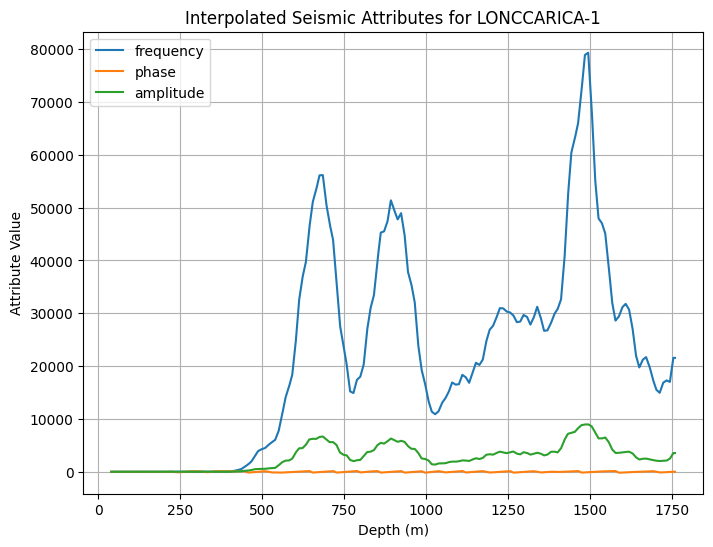

In [15]:
# plot the seismic attributes
for well_name, data in interpolated_seismic_data.items():
    plt.figure(figsize=(8, 6))
    for column in data.columns:
        plt.plot(data.index, data[column], label=column)
    plt.title(f"Interpolated Seismic Attributes for {well_name}")
    plt.xlabel("Depth (m)")
    plt.ylabel("Attribute Value")
    plt.legend()
    plt.grid()
    plt.show()


In [16]:
# check seismic data correlation for each well
for well_name, data in interpolated_seismic_data.items():
    correlation = data.corr()
    print(f"Correlation Matrix for {well_name}:\n{correlation}\n")


Correlation Matrix for REZOVACCKE_KRCCEVINE-1:
           frequency     phase  amplitude
frequency   1.000000  0.014659   0.994399
phase       0.014659  1.000000   0.029337
amplitude   0.994399  0.029337   1.000000

Correlation Matrix for REZOVACCKE_KRCCEVINE-2:
           frequency     phase  amplitude
frequency   1.000000 -0.027969   0.995284
phase      -0.027969  1.000000  -0.012636
amplitude   0.995284 -0.012636   1.000000

Correlation Matrix for SUHOPOLJE-1:
           frequency     phase  amplitude
frequency   1.000000 -0.033206   0.994756
phase      -0.033206  1.000000  -0.017816
amplitude   0.994756 -0.017816   1.000000

Correlation Matrix for VIROVITICA-1:
           frequency     phase  amplitude
frequency   1.000000 -0.001041   0.994345
phase      -0.001041  1.000000   0.016886
amplitude   0.994345  0.016886   1.000000

Correlation Matrix for VIROVITICA-3ALFA:
           frequency    phase  amplitude
frequency   1.000000  0.01102   0.995695
phase       0.011020  1.00000   0.

In [ ]:
# Impute missing values in seismic data for each well
#imputed_seismic_data = {}

#for well_name, data in interpolated_seismic_data.items():
#    df = data.copy()  # Copy the DataFrame for safety
#
#    # Impute missing values using forward-fill and backward-fill
#    df = df.fillna(method='ffill').fillna(method='bfill')

    # Store the imputed DataFrame
#    imputed_seismic_data[well_name] = df

    # Display summary of missing values after imputation
#    missing_values_after = df.isnull().mean()
#    print(f"{well_name} - Missing Data Percentage After Imputation:\n{missing_values_after}")


In [17]:
# normalize the seismic data
from sklearn.preprocessing import MinMaxScaler

# Initialize a scaler
scaler = MinMaxScaler()

# Normalize seismic data for each well
normalized_seismic_data = {}

for well_name, data in interpolated_seismic_data.items():
    df = data.copy()  # Copy the DataFrame

    # Normalize each attribute
    normalized_values = scaler.fit_transform(df)
    normalized_df = pd.DataFrame(normalized_values, columns=df.columns, index=df.index)

    # Store the normalized DataFrame
    normalized_seismic_data[well_name] = normalized_df

    # Print a summary
    print(f"{well_name} - Normalized Data Range:\n")
    print(normalized_df.describe())


REZOVACCKE_KRCCEVINE-1 - Normalized Data Range:

          frequency         phase     amplitude
count  33101.000000  33101.000000  33101.000000
mean       0.271675      0.502525      0.298212
std        0.200526      0.247205      0.213652
min        0.000000      0.000000      0.000000
25%        0.136302      0.300257      0.158061
50%        0.262237      0.497880      0.279025
75%        0.412190      0.722522      0.453749
max        1.000000      1.000000      1.000000
REZOVACCKE_KRCCEVINE-2 - Normalized Data Range:

          frequency         phase     amplitude
count  45541.000000  45541.000000  45541.000000
mean       0.343918      0.507220      0.367108
std        0.234556      0.248842      0.240777
min        0.000000      0.000000      0.000000
25%        0.163425      0.300471      0.190998
50%        0.297594      0.497880      0.334378
75%        0.503330      0.725688      0.526061
max        1.000000      1.000000      1.000000
SUHOPOLJE-1 - Normalized Data Range:



In [18]:
# Seismic and well log depth alignment
# Ensure well_depths is a dictionary
if not isinstance(well_depths, dict):
    raise TypeError("well_depths must be a dictionary with well names as keys and depth arrays as values.")

# Initialize a dictionary to store the merged data
merged_data = {}

# Loop through each well
for well_name, well_depth_array in well_depths.items():
    print(f"Processing {well_name}...")

    # Retrieve seismic data for the current well
    df_seismic = interpolated_seismic_data.get(well_name)
    if df_seismic is None:
        print(f"No seismic data available for {well_name}. Filling with NaN values...")
        df_seismic = pd.DataFrame(index=well_depth_array)  # Create empty DataFrame with well depth as index

    # Align seismic data with well depths
    aligned_data = pd.DataFrame(index=well_depth_array, columns=df_seismic.columns)  # Use well depths as the index
    aligned_data.update(df_seismic)  # Update with seismic data

    # Retrieve well log data for the current well
    df_well_logs = well_data.get(well_name)
    if df_well_logs is None:
        print(f"No well log data available for {well_name}. Filling with NaN values...")
        df_well_logs = pd.DataFrame(index=well_depth_array)  # Create empty DataFrame with well depth as index
        df_well_logs["Depth"] = well_depth_array  # Ensure a "Depth" column exists

    # Merge aligned seismic data with well log data
    merged_df = aligned_data.join(df_well_logs.set_index("Depth"), how="outer")  # Use "outer" to ensure no data is lost

    # Fill missing values if required
    merged_df.fillna(0, inplace=True)  # Replace `0` with appropriate default values

    # Store the merged dataset
    merged_data[well_name] = merged_df

    print(f"Merged data for {well_name}:")
    print(merged_df.head())  # Display a preview of the merged dataset

# Final summary of merged datasets
print("\nMerged datasets are ready for all wells:")
for well_name, df in merged_data.items():
    print(f"{well_name} - Data Shape: {df.shape}")


Processing REZOVACCKE_KRCCEVINE-1...
Merged data for REZOVACCKE_KRCCEVINE-1:
    frequency phase amplitude   AC  CALI  NPHI  RHOB   GR   R64  TEMP   R16  \
0.0       0.0   0.0       0.0  0.0   0.0   0.0   0.0  0.0  4.38   0.0  8.37   
0.1       0.0   0.0       0.0  0.0   0.0   0.0   0.0  0.0  4.38   0.0  8.37   
0.2       0.0   0.0       0.0  0.0   0.0   0.0   0.0  0.0  4.38   0.0  8.37   
0.3       0.0   0.0       0.0  0.0   0.0   0.0   0.0  0.0  4.38   0.0  8.37   
0.4       0.0   0.0       0.0  0.0   0.0   0.0   0.0  0.0  4.38   0.0  8.37   

      SP  RLML  RNML  RSHALLOW  RDEEP  RMEDIUM  PHIE  PHIT  
0.0  2.6   0.0   0.0       0.0    0.0      0.0   0.0   0.0  
0.1  2.6   0.0   0.0       0.0    0.0      0.0   0.0   0.0  
0.2  2.6   0.0   0.0       0.0    0.0      0.0   0.0   0.0  
0.3  2.6   0.0   0.0       0.0    0.0      0.0   0.0   0.0  
0.4  2.6   0.0   0.0       0.0    0.0      0.0   0.0   0.0  
Processing REZOVACCKE_KRCCEVINE-2...
Merged data for REZOVACCKE_KRCCEVINE-2:
    f

In [19]:
# Check for missing values in each well's merged data
for well_name, merged_df in merged_data.items():
    missing_percentage = merged_df.isnull().mean() * 100
    print(f"{well_name} - Missing Data Percentage:")
    print(missing_percentage)
    print()


REZOVACCKE_KRCCEVINE-1 - Missing Data Percentage:
frequency    0.0
phase        0.0
amplitude    0.0
AC           0.0
CALI         0.0
NPHI         0.0
RHOB         0.0
GR           0.0
R64          0.0
TEMP         0.0
R16          0.0
SP           0.0
RLML         0.0
RNML         0.0
RSHALLOW     0.0
RDEEP        0.0
RMEDIUM      0.0
PHIE         0.0
PHIT         0.0
dtype: float64

REZOVACCKE_KRCCEVINE-2 - Missing Data Percentage:
frequency    0.0
phase        0.0
amplitude    0.0
NPHI         0.0
RHOB         0.0
GR           0.0
CALI         0.0
SP           0.0
AC           0.0
RDEEP        0.0
RSHALLOW     0.0
RMEDIUM      0.0
R16          0.0
R64          0.0
VSHALE       0.0
RLML         0.0
RNML         0.0
dtype: float64

SUHOPOLJE-1 - Missing Data Percentage:
frequency    0.0
phase        0.0
amplitude    0.0
AC           0.0
CALI         0.0
NPHI         0.0
RHOB         0.0
GR           0.0
RLML         0.0
RNML         0.0
SP           0.0
RDEEP        0.0
RMEDIUM      

In [20]:
# Inspect the columns in the merged datasets
for well_name, merged_df in merged_data.items():
    print(f"{well_name} - Columns:")
    print(merged_df.columns)
    print()


REZOVACCKE_KRCCEVINE-1 - Columns:
Index(['frequency', 'phase', 'amplitude', 'AC', 'CALI', 'NPHI', 'RHOB', 'GR',
       'R64', 'TEMP', 'R16', 'SP', 'RLML', 'RNML', 'RSHALLOW', 'RDEEP',
       'RMEDIUM', 'PHIE', 'PHIT'],
      dtype='object')

REZOVACCKE_KRCCEVINE-2 - Columns:
Index(['frequency', 'phase', 'amplitude', 'NPHI', 'RHOB', 'GR', 'CALI', 'SP',
       'AC', 'RDEEP', 'RSHALLOW', 'RMEDIUM', 'R16', 'R64', 'VSHALE', 'RLML',
       'RNML'],
      dtype='object')

SUHOPOLJE-1 - Columns:
Index(['frequency', 'phase', 'amplitude', 'AC', 'CALI', 'NPHI', 'RHOB', 'GR',
       'RLML', 'RNML', 'SP', 'RDEEP', 'RMEDIUM', 'RSHALLOW'],
      dtype='object')

VIROVITICA-1 - Columns:
Index(['frequency', 'phase', 'amplitude', 'R64', 'TEMP', 'CALI', 'R16', 'SP',
       'RDEEP', 'RLML', 'RNML'],
      dtype='object')

VIROVITICA-3ALFA - Columns:
Index(['frequency', 'phase', 'amplitude', 'AC', 'CALI', 'NPHI', 'RHOB', 'GR',
       'PERM', 'PHIE', 'PHIT', 'SP', 'VSHALE', 'RDEEP', 'R64', 'RNML'],
      dt

In [21]:
# Inspect depth ranges in merged data
for well_name, merged_df in merged_data.items():
    depth_range = (merged_df.index.min(), merged_df.index.max())
    print(f"{well_name} - Depth Range: {depth_range}")


REZOVACCKE_KRCCEVINE-1 - Depth Range: (0.0, 3310.0)
REZOVACCKE_KRCCEVINE-2 - Depth Range: (1.0, 4555.0)
SUHOPOLJE-1 - Depth Range: (215.0, 4985.0)
VIROVITICA-1 - Depth Range: (50.0, 2895.0)
VIROVITICA-3ALFA - Depth Range: (100.0, 3926.8)
LONCCARICA-1 - Depth Range: (40.0, 1760.0)


In [22]:
# Generate descriptive statistics for merged data
for well_name, merged_df in merged_data.items():
    print(f"{well_name} - Data Statistics:")
    print(merged_df.describe())
    print()


REZOVACCKE_KRCCEVINE-1 - Data Statistics:
                 AC          CALI          NPHI          RHOB            GR  \
count  33101.000000  33101.000000  33101.000000  33101.000000  33101.000000   
mean      58.629376     11.243463     17.328137      2.020186     19.184974   
std       32.051470      5.948663     11.790398      1.035263     18.056823   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%       55.637001     11.322000      9.250000      2.304000      0.000000   
50%       67.163002     13.317000     17.219999      2.512000     26.281000   
75%       79.681000     15.135000     26.000000      2.622000     34.991001   
max      144.522003     17.781000     44.000000      2.863000     60.137001   

                R64          TEMP           R16            SP          RLML  \
count  33101.000000  33101.000000  33101.000000  33101.000000  33101.000000   
mean      24.671275     70.642689     18.627713     52.142384     16.824578   
std      

In [23]:
# Add placeholders for unknown wells separately
unknown_wells_data = {}
unknown_wells = ["UNKNOWNWELL1", "UNKNOWNWELL2"]

for unknown_well in unknown_wells:
    print(f"Adding placeholder data for {unknown_well}...")
    # Generate placeholder depth array (adjust range as needed)
    placeholder_depth = pd.Series(range(0, 100, 10))  # Example: depths 0 to 100 in increments of 10
    placeholder_df = pd.DataFrame(index=placeholder_depth)
    placeholder_df["Depth"] = placeholder_depth
    placeholder_df.fillna(0, inplace=True)  # Replace with appropriate default values
    unknown_wells_data[unknown_well] = placeholder_df


Adding placeholder data for UNKNOWNWELL1...
Adding placeholder data for UNKNOWNWELL2...


In [24]:
# Separate known wells from unknown wells
known_wells = [k for k in merged_data.keys() if k not in unknown_wells]

# Impute missing values for known wells only
imputed_data = {}
for well_name in known_wells:
    df = merged_data[well_name]
    df = df.fillna(df.mean())  # Use mean imputation for simplicity
    imputed_data[well_name] = df

# Verify imputation for known wells
for well_name, df in imputed_data.items():
    print(f"{well_name} - Missing Data After Imputation:")
    print(df.isnull().mean() * 100)  # Percent missing for each column
    print()


<ipython-input-24-0a143d03c974>:8: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.fillna(df.mean())  # Use mean imputation for simplicity
<ipython-input-24-0a143d03c974>:8: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.fillna(df.mean())  # Use mean imputation for simplicity
<ipython-input-24-0a143d03c974>:8: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no

REZOVACCKE_KRCCEVINE-1 - Missing Data After Imputation:
frequency    0.0
phase        0.0
amplitude    0.0
AC           0.0
CALI         0.0
NPHI         0.0
RHOB         0.0
GR           0.0
R64          0.0
TEMP         0.0
R16          0.0
SP           0.0
RLML         0.0
RNML         0.0
RSHALLOW     0.0
RDEEP        0.0
RMEDIUM      0.0
PHIE         0.0
PHIT         0.0
dtype: float64

REZOVACCKE_KRCCEVINE-2 - Missing Data After Imputation:
frequency    0.0
phase        0.0
amplitude    0.0
NPHI         0.0
RHOB         0.0
GR           0.0
CALI         0.0
SP           0.0
AC           0.0
RDEEP        0.0
RSHALLOW     0.0
RMEDIUM      0.0
R16          0.0
R64          0.0
VSHALE       0.0
RLML         0.0
RNML         0.0
dtype: float64

SUHOPOLJE-1 - Missing Data After Imputation:
frequency    0.0
phase        0.0
amplitude    0.0
AC           0.0
CALI         0.0
NPHI         0.0
RHOB         0.0
GR           0.0
RLML         0.0
RNML         0.0
SP           0.0
RDEEP       

Feature engineering

In [25]:
from sklearn.cluster import KMeans
# Combine all imputed well data into a single DataFrame
combined_data = pd.concat(imputed_data.values(), keys=imputed_data.keys(), names=["Well Name", "Index"]).reset_index()

# Extract only numerical columns for clustering
numerical_columns = combined_data.select_dtypes(include=["float64", "int64"]).columns

# Ensure unknown wells are represented with valid numerical values
combined_data[numerical_columns] = combined_data[numerical_columns].fillna(combined_data[numerical_columns].mean())

# Scale the data for clustering
scaler = StandardScaler()
scaled_data = scaler.fit_transform(combined_data[numerical_columns])


# Perform K-means clustering
optimal_k = 4  # Based on prior analysis
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
combined_data["Cluster"] = kmeans.fit_predict(scaled_data)
print(f"Scaled Data Shape: {scaled_data.shape}")


Scaled Data Shape: (210264, 22)


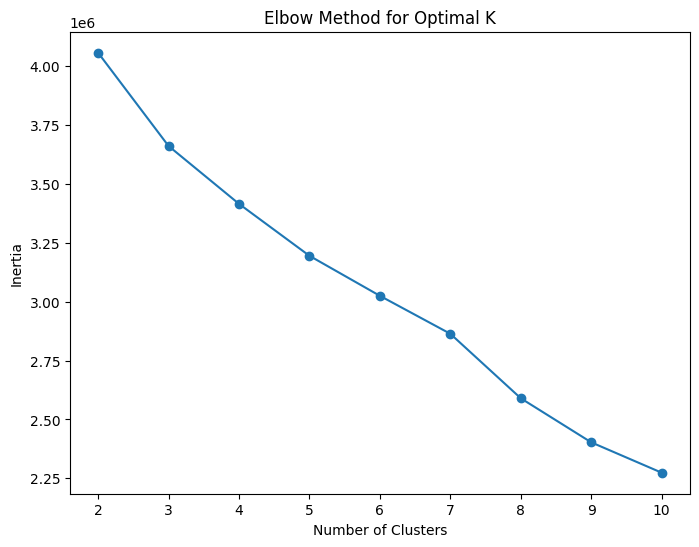

In [26]:
# Test different k values (elbow method)
inertia = []
k_values = range(2, 11)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_data)
    inertia.append(kmeans.inertia_)

# Plot the elbow curve
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.plot(k_values, inertia, marker="o")
plt.title("Elbow Method for Optimal K")
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")
plt.show()


In [27]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

# Normalize the entire dataset (post-clustering and imputation)
scaler = MinMaxScaler()
columns_to_normalize = [
    col for col in combined_data.columns
    if col not in ["Well Name", "Index", "Cluster"] and combined_data[col].dtype in ["float64", "int64"]
]
combined_data[columns_to_normalize] = scaler.fit_transform(combined_data[columns_to_normalize])



In [28]:
# Separate known and unknown wells
known_wells = combined_data[combined_data["Well Name"].isin(imputed_data.keys())]
unknown_wells = combined_data[~combined_data["Well Name"].isin(imputed_data.keys())]

print(f"Known wells count: {known_wells.shape[0]}")
print(f"Unknown wells count: {unknown_wells.shape[0]}")


Known wells count: 210264
Unknown wells count: 0


In [29]:
# Optimal number of clusters determined by elbow method
optimal_k = 4
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
combined_data["Cluster"] = kmeans.fit_predict(scaled_data)

# Impute missing values within each cluster
imputed_cluster_data = combined_data.copy()

for cluster_id in combined_data["Cluster"].unique():
    cluster_data = combined_data[combined_data["Cluster"] == cluster_id]
    cluster_means = cluster_data[numerical_columns].mean()

    for col in numerical_columns:
        imputed_cluster_data.loc[
            (imputed_cluster_data["Cluster"] == cluster_id) & (imputed_cluster_data[col].isnull()), col
        ] = cluster_means[col]

# Drop the cluster column
imputed_cluster_data = imputed_cluster_data.drop(columns=["Cluster"])


# Verify cluster assignments
print(combined_data["Cluster"].value_counts())

Cluster
3    75223
1    59065
0    38756
2    37220
Name: count, dtype: int64


In [30]:
from sklearn.preprocessing import MinMaxScaler

# Initialize scaler
scaler = MinMaxScaler()

# Ensure `imputed_cluster_data` contains both known and unknown wells
if 'Well Name' not in imputed_cluster_data.columns:
    raise ValueError("Column 'Well Name' is missing in `imputed_cluster_data`.")

# Create a copy of the combined data for normalization
normalized_combined_data = imputed_cluster_data.copy()

# Define seismic attributes and other columns to normalize
seismic_cols = ["frequency", "phase", "amplitude"]
numerical_columns = [
    col for col in normalized_combined_data.columns
    if col not in ["Well Name", "Depth"]  # Exclude identifiers and non-numerical columns
    and normalized_combined_data[col].dtype in ["float64", "int64"]
]

# Check for presence of seismic attributes
existing_seismic_cols = [col for col in seismic_cols if col in numerical_columns]

# Normalize seismic attributes if present
if existing_seismic_cols:
    print(f"Normalizing seismic attributes: {existing_seismic_cols}")
    try:
        normalized_combined_data[existing_seismic_cols] = scaler.fit_transform(
            normalized_combined_data[existing_seismic_cols]
        )
    except Exception as e:
        print(f"Error normalizing seismic attributes: {e}")

# Normalize all other numerical columns
columns_to_normalize = [col for col in numerical_columns if col not in seismic_cols]
if columns_to_normalize:
    print(f"Normalizing other numerical columns: {columns_to_normalize}")
    try:
        normalized_combined_data[columns_to_normalize] = scaler.fit_transform(
            normalized_combined_data[columns_to_normalize]
        )
    except Exception as e:
        print(f"Error normalizing other numerical columns: {e}")

# Print summary of normalized data
print("\nNormalized Combined Data Summary:")
print(normalized_combined_data.describe())

# Verify unknown wells are included
unknown_wells = normalized_combined_data[~normalized_combined_data["Well Name"].isin(imputed_data.keys())]
print(f"\nUnknown wells after normalization: {unknown_wells.shape[0]}")
if unknown_wells.empty:
    print("Warning: No unknown wells detected after normalization.")


Normalizing seismic attributes: ['frequency', 'phase', 'amplitude']
Normalizing other numerical columns: ['Index', 'AC', 'CALI', 'NPHI', 'RHOB', 'GR', 'R64', 'TEMP', 'R16', 'SP', 'RLML', 'RNML', 'RSHALLOW', 'RDEEP', 'RMEDIUM', 'PHIE', 'PHIT', 'VSHALE', 'PERM']

Normalized Combined Data Summary:
               Index      frequency          phase      amplitude  \
count  210264.000000  210264.000000  210264.000000  210264.000000   
mean        0.397812       0.313403       0.504789       0.335649   
std         0.248564       0.223443       0.248163       0.230766   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.189308       0.151535       0.298694       0.167587   
50%         0.367462       0.277051       0.497880       0.292557   
75%         0.578355       0.451503       0.725438       0.488403   
max         1.000000       1.000000       1.000000       1.000000   

                  AC           CALI           NPHI           RHOB  \
count  210264

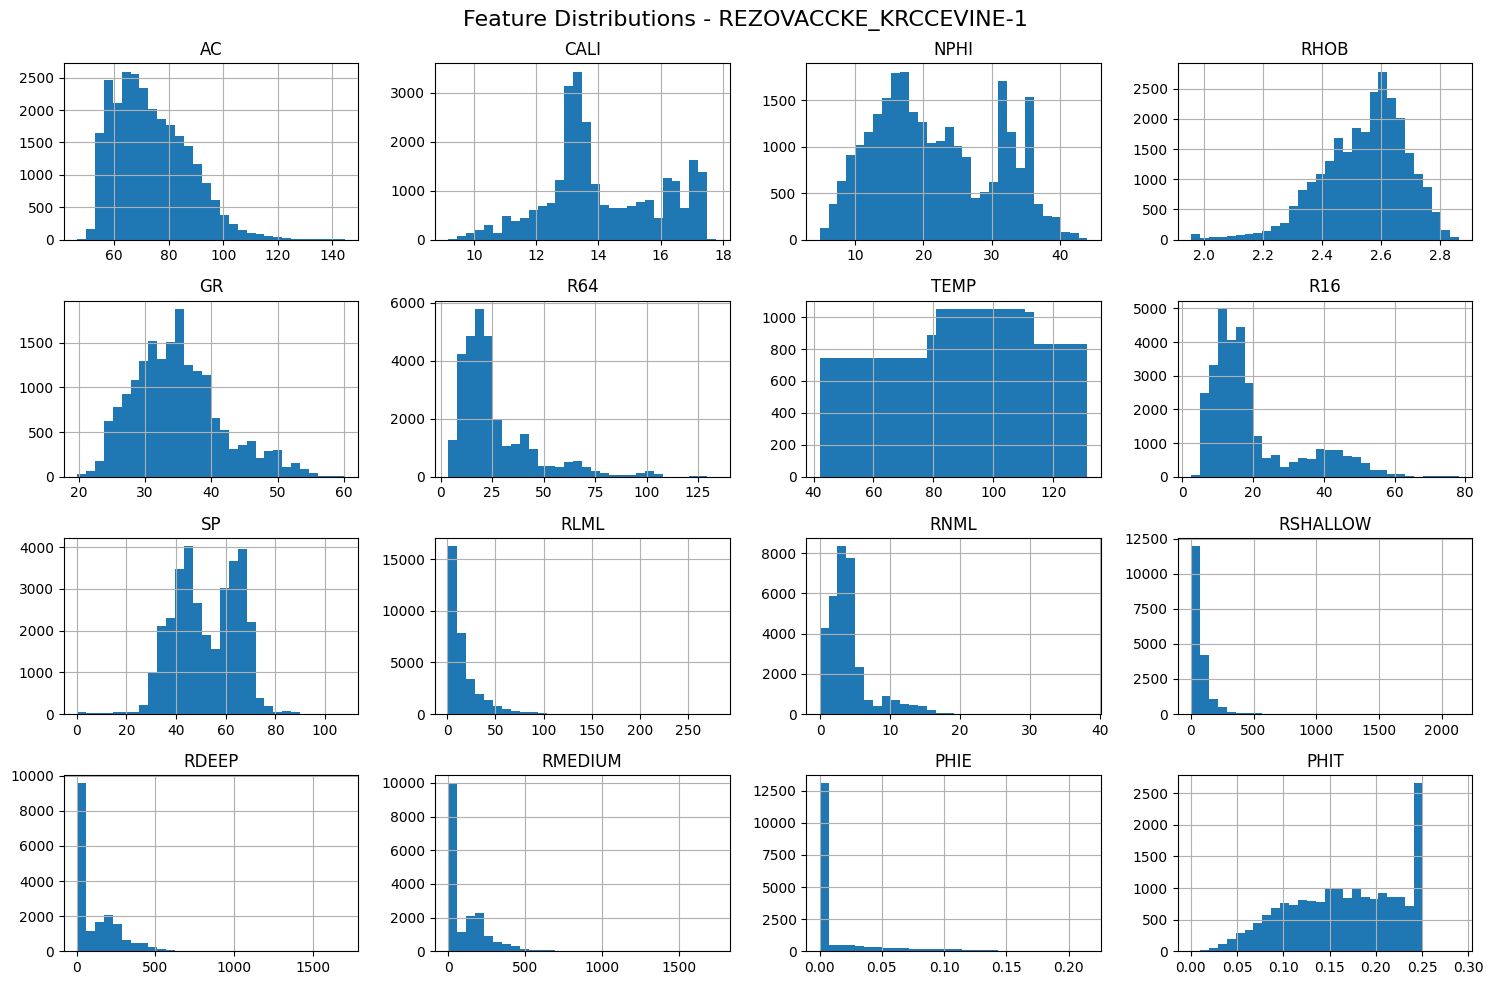

In [ ]:
# Select one well dataset to visualize (e.g., REZOVACCKE_KRCCEVINE-1)
test_well = "REZOVACCKE_KRCCEVINE-1"
test_data = merged_data[test_well]

# Plot histograms for all numeric features
numeric_columns = test_data.select_dtypes(include=['float64', 'int64']).columns
test_data[numeric_columns].hist(bins=30, figsize=(15, 10))
plt.suptitle(f"Feature Distributions - {test_well}", fontsize=16)
plt.tight_layout()
plt.show()


In [31]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# Updated dataset structure for wells
data = {
    "Well Name": [
        "REZOVACCKE_KRCCEVINE-1",
        "REZOVACCKE_KRCCEVINE-2",
        "SUHOPOLJE-1",
        "VIROVITICA-1",
        "VIROVITICA-3 ALFA",
        "LONCCARICA-1",
        "Unknown Well 1",
        "Unknown Well 2",
    ],
    "Surface X": [
        689340.71, 688872.79, 693135.92, 685448.76, 686218.75, 680935.09, 683447.00, 691636.00
    ],
    "Surface Y": [
        5072557.33, 5073318.89, 5073660.97, 5073267.09, 5073539.22, 5070578.64, 5072765.00, 5072723.00
    ],
    "TD (MD)": [
        3312.0, 4554.0, 4987.5, 2956.5, 4087.0, 1764.0, 2034.0, 5435.0
    ],
    "Average Porosity (%)": [
        8, 3, 5, 13, 5, 18, None, None
    ],
    "Max Porosity (%)": [
        21, 16.5, 8, 33, 16.1, 40, None, None
    ],
    "Average Permeability (mD)": [
        0.43, 0.1, 4.4, 2.43, 0.43, 11.8, None, None
    ],
    "Max Permeability (mD)": [
        2.5, 1, 10, 2.9, 5.6, 79.7, None, None
    ],
    "Temperature (°C)": [
        131.5, 162, 205, 117, 199, 81, None, None
    ],
}

# Convert to DataFrame
well_data_df = pd.DataFrame(data)

# Handle missing values (impute with column mean for numerical data)
numerical_cols = [
    "Surface X", "Surface Y", "TD (MD)", "Average Porosity (%)",
    "Max Porosity (%)", "Average Permeability (mD)",
    "Max Permeability (mD)", "Temperature (°C)"
]

# Impute missing values for numerical columns
well_data_df[numerical_cols] = well_data_df[numerical_cols].apply(lambda col: col.fillna(col.mean()))

# Ensure `imputed_cluster_data` is correctly formatted
if "Well Name" not in imputed_cluster_data.columns:
    raise ValueError("The column 'Well Name' is missing in `imputed_cluster_data`.")

# Reset index for merging
imputed_cluster_data = imputed_cluster_data.reset_index()
well_data_df = well_data_df.reset_index(drop=True)  # Ensure clean index for well_data_df

# Align the two datasets and merge on "Well Name"
aligned_data = imputed_cluster_data.merge(well_data_df, on="Well Name", how="outer")

# Normalize the numerical columns across the combined dataset
scaler = MinMaxScaler()
columns_to_normalize = [
    col for col in aligned_data.columns
    if aligned_data[col].dtype in ["float64", "int64"] and col != "Well Name"
]

print(f"Columns to be normalized: {columns_to_normalize}")

# Apply MinMaxScaler to normalize numerical columns
aligned_data[columns_to_normalize] = scaler.fit_transform(aligned_data[columns_to_normalize])

# Reset index for final usage
final_combined_data = aligned_data.reset_index(drop=True)

# Verify the updated dataset
print("Final Combined Data Summary:")
print(final_combined_data.describe())
print("\nSample rows from Final Combined Data:")
print(final_combined_data.head())

# Verify unknown wells are included
unknown_wells = final_combined_data[
    ~final_combined_data["Well Name"].isin(imputed_cluster_data["Well Name"])
]
print(f"\nUnknown wells count after merging: {unknown_wells.shape[0]}")
print("Sample rows from unknown wells:")
print(unknown_wells.head())


Columns to be normalized: ['index', 'Index', 'frequency', 'phase', 'amplitude', 'AC', 'CALI', 'NPHI', 'RHOB', 'GR', 'R64', 'TEMP', 'R16', 'SP', 'RLML', 'RNML', 'RSHALLOW', 'RDEEP', 'RMEDIUM', 'PHIE', 'PHIT', 'VSHALE', 'PERM', 'Surface X', 'Surface Y', 'TD (MD)', 'Average Porosity (%)', 'Max Porosity (%)', 'Average Permeability (mD)', 'Max Permeability (mD)', 'Temperature (°C)']
Final Combined Data Summary:
               index          Index      frequency          phase  \
count  210264.000000  210264.000000  210264.000000  210264.000000   
mean        0.500000       0.397812       0.313403       0.504789   
std         0.288677       0.248564       0.223443       0.248163   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.250000       0.189308       0.151535       0.298694   
50%         0.500000       0.367462       0.277051       0.497880   
75%         0.750000       0.578355       0.451503       0.725438   
max         1.000000       1.000000   

In [32]:
well_data_df = well_data_df.reset_index()
print("Well Names in `well_data_df`:")
print(well_data_df["Well Name"].unique())

Well Names in `well_data_df`:
['REZOVACCKE_KRCCEVINE-1' 'REZOVACCKE_KRCCEVINE-2' 'SUHOPOLJE-1'
 'VIROVITICA-1' 'VIROVITICA-3 ALFA' 'LONCCARICA-1' 'Unknown Well 1'
 'Unknown Well 2']


In [33]:
# Step 1: Dynamically extract data for known and unknown wells from `final_combined_data`
# Identify known and unknown wells based on `imputed_data` keys
known_wells = final_combined_data[final_combined_data["Well Name"].isin(imputed_data.keys())]
unknown_wells = final_combined_data[~final_combined_data["Well Name"].isin(imputed_data.keys())]

# Verify the counts
print(f"Number of known wells: {known_wells['Well Name'].nunique()}")
print(f"Number of unknown wells: {unknown_wells['Well Name'].nunique()}")

# Initialize a list to hold combined data for known wells
known_wells_with_logs = []

# Step 2: Add well logs to known wells
for well_name in known_wells["Well Name"].unique():
    if well_name in imputed_data:
        # Retrieve well logs for the current well
        well_logs = imputed_data[well_name].reset_index()  # Ensure well logs are in DataFrame format

        # Retrieve metadata for the current well
        well_metadata = known_wells[known_wells["Well Name"] == well_name].iloc[0]

        # Add metadata columns to the well logs
        for col in well_metadata.index:
            if col not in well_logs.columns:  # Only add metadata if it doesn't already exist in well logs
                well_logs[col] = well_metadata[col]

        # Append the updated DataFrame to the list
        known_wells_with_logs.append(well_logs)
    else:
        print(f"Logs for {well_name} not found in `imputed_data`. Skipping...")

# Combine all known wells data into a single DataFrame
if known_wells_with_logs:
    combined_known_wells = pd.concat(known_wells_with_logs, ignore_index=True)
else:
    combined_known_wells = pd.DataFrame()  # Empty DataFrame if no logs found

# Step 3: Prepare unknown wells for further processing
if not unknown_wells.empty:
    # Ensure consistent columns for unknown wells
    unknown_wells = unknown_wells[combined_known_wells.columns.intersection(unknown_wells.columns)]
else:
    print("No unknown wells found after filtering.")

# Step 4: Verify the results
print(f"Shape of combined `known_wells_with_logs`: {combined_known_wells.shape}")
print("Columns in combined `known_wells_with_logs`:")
print(combined_known_wells.columns)

print("\nSample rows from `combined_known_wells`:")
print(combined_known_wells.head())

print("\nShape of `unknown_wells`: ", unknown_wells.shape)
if not unknown_wells.empty:
    print("Sample rows from `unknown_wells`:")
    print(unknown_wells.head())

# Optional: Save outputs to CSV for verification
combined_known_wells.to_csv("known_wells_combined.csv", index=False)
if not unknown_wells.empty:
    unknown_wells.to_csv("unknown_wells_filtered.csv", index=False)


Number of known wells: 6
Number of unknown wells: 3
Shape of combined `known_wells_with_logs`: (210264, 32)
Columns in combined `known_wells_with_logs`:
Index(['index', 'frequency', 'phase', 'amplitude', 'CALI', 'TEMP', 'AC', 'SP',
       'R16', 'R64', 'RLML', 'RNML', 'Well Name', 'Index', 'NPHI', 'RHOB',
       'GR', 'RSHALLOW', 'RDEEP', 'RMEDIUM', 'PHIE', 'PHIT', 'VSHALE', 'PERM',
       'Surface X', 'Surface Y', 'TD (MD)', 'Average Porosity (%)',
       'Max Porosity (%)', 'Average Permeability (mD)',
       'Max Permeability (mD)', 'Temperature (°C)'],
      dtype='object')

Sample rows from `combined_known_wells`:
   index  frequency  phase  amplitude       CALI  TEMP   AC         SP    R16  \
0   40.0        0.0    0.0        0.0  16.768999   0.0  0.0  99.094002  0.226   
1   40.1        0.0    0.0        0.0  16.768999   0.0  0.0  99.094002  0.226   
2   40.2        0.0    0.0        0.0  16.768999   0.0  0.0  99.094002  0.226   
3   40.3        0.0    0.0        0.0  16.768999 

In [ ]:
# # Fallback: Use keys from `imputed_data` or `merged_data` if `normalized_data` is empty
# if not normalized_data:
#     print("`normalized_data` is empty. Falling back to keys from `imputed_data` or `merged_data`.")
#     known_well_names = list(imputed_data.keys()) if imputed_data else list(merged_data.keys())
# else:
#     known_well_names = list(normalized_data.keys())

# print("Final known well names:", known_well_names)

# # Separate known and unknown wells dynamically
# known_wells = final_combined_data[final_combined_data["Well Name"].isin(known_well_names)]
# unknown_wells = final_combined_data[~final_combined_data["Well Name"].isin(known_well_names)]

# # Verify separation
# print(f"Shape of known wells: {known_wells.shape}")
# print(f"Shape of unknown wells: {unknown_wells.shape}")

# # Save to CSV
# if not known_wells.empty:
#     known_wells.to_csv("known_wells.csv", index=False)
#     print("Known wells saved to 'known_wells.csv'.")

# if not unknown_wells.empty:
#     unknown_wells.to_csv("unknown_wells.csv", index=False)
#     print("Unknown wells saved to 'unknown_wells.csv'.")
# else:
#     print("No unknown wells to save.")


In [34]:
# List available columns to debug
print("Columns in known_dataset before feature selection:")
print(combined_known_wells.columns)
print(unknown_wells.columns)


Columns in known_dataset before feature selection:
Index(['index', 'frequency', 'phase', 'amplitude', 'CALI', 'TEMP', 'AC', 'SP',
       'R16', 'R64', 'RLML', 'RNML', 'Well Name', 'Index', 'NPHI', 'RHOB',
       'GR', 'RSHALLOW', 'RDEEP', 'RMEDIUM', 'PHIE', 'PHIT', 'VSHALE', 'PERM',
       'Surface X', 'Surface Y', 'TD (MD)', 'Average Porosity (%)',
       'Max Porosity (%)', 'Average Permeability (mD)',
       'Max Permeability (mD)', 'Temperature (°C)'],
      dtype='object')
Index(['index', 'frequency', 'phase', 'amplitude', 'CALI', 'TEMP', 'AC', 'SP',
       'R16', 'R64', 'RLML', 'RNML', 'Well Name', 'Index', 'NPHI', 'RHOB',
       'GR', 'RSHALLOW', 'RDEEP', 'RMEDIUM', 'PHIE', 'PHIT', 'VSHALE', 'PERM',
       'Surface X', 'Surface Y', 'TD (MD)', 'Average Porosity (%)',
       'Max Porosity (%)', 'Average Permeability (mD)',
       'Max Permeability (mD)', 'Temperature (°C)'],
      dtype='object')


In [35]:
# Dynamically identify and drop redundant "_y" columns
columns_to_drop = [col for col in combined_known_wells.columns if "_y" in col]
columns_to_rename = {col: col.replace("_x", "") for col in combined_known_wells.columns if "_x" in col}

# Clean the dataset
known_dataset_cleaned = combined_known_wells.drop(columns=columns_to_drop, errors="ignore").rename(columns=columns_to_rename)

# Check cleaned columns
print("Columns in cleaned known_dataset:")
print(known_dataset_cleaned.columns)

# Step 1: Ensure feature columns are consistent
feature_columns = [
    "GR", "RHOB", "NPHI", "RDEEP", "RSHALLOW",  # Well logs
    "frequency", "phase", "amplitude",          # Seismic attributes
    "Surface X", "Surface Y", "TD (MD)",        # Location and depth
    "VSHALE",                                   # Cluster-relevant features
    "Average Porosity (%)", "Max Porosity (%)",  # Include porosity as features
    "Average Permeability (mD)", "Max Permeability (mD)",  # Include permeability as features
    "Temperature (°C)"                          # Include temperature if relevant
]

# Check for missing features in the dataset
missing_features = [col for col in feature_columns if col not in known_dataset_cleaned.columns]
if missing_features:
    print(f"Warning: The following features are missing and will be excluded: {missing_features}")

# Only include features present in the dataset
feature_columns = [col for col in feature_columns if col in known_dataset_cleaned.columns]

# Step 2: Ensure target columns are consistent
target_columns = [
    "Average Porosity (%)", "Max Porosity (%)",
    "Average Permeability (mD)", "Max Permeability (mD)", "Temperature (°C)"
]

# Check for missing targets in the dataset
missing_targets = [col for col in target_columns if col not in known_dataset_cleaned.columns]
if missing_targets:
    print(f"Warning: The following targets are missing and will be excluded: {missing_targets}")

# Only include targets present in the dataset
target_columns = [col for col in target_columns if col in known_dataset_cleaned.columns]

# Step 3: Create feature and target datasets
if feature_columns:
    X_train = known_dataset_cleaned[feature_columns]
else:
    print("Error: No valid feature columns found.")
    X_train = pd.DataFrame()  # Create an empty DataFrame as a fallback

if target_columns:
    y_train = known_dataset_cleaned[target_columns]
else:
    print("Error: No valid target columns found.")
    y_train = pd.DataFrame()  # Create an empty DataFrame as a fallback

# Print shapes of feature and target datasets
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")

# Verify the first few rows
if not X_train.empty:
    print("First few rows of X_train:")
    print(X_train.head())
else:
    print("X_train is empty. Please check your data processing pipeline.")

if not y_train.empty:
    print("First few rows of y_train:")
    print(y_train.head())
else:
    print("y_train is empty. Please check your data processing pipeline.")


Columns in cleaned known_dataset:
Index(['index', 'frequency', 'phase', 'amplitude', 'CALI', 'TEMP', 'AC', 'SP',
       'R16', 'R64', 'RLML', 'RNML', 'Well Name', 'Index', 'NPHI', 'RHOB',
       'GR', 'RSHALLOW', 'RDEEP', 'RMEDIUM', 'PHIE', 'PHIT', 'VSHALE', 'PERM',
       'Surface X', 'Surface Y', 'TD (MD)', 'Average Porosity (%)',
       'Max Porosity (%)', 'Average Permeability (mD)',
       'Max Permeability (mD)', 'Temperature (°C)'],
      dtype='object')
X_train shape: (210264, 17)
y_train shape: (210264, 5)
First few rows of X_train:
         GR      RHOB      NPHI    RDEEP  RSHALLOW  frequency  phase  \
0  0.299231  0.420918  0.178574  0.02591  0.027465        0.0    0.0   
1  0.299231  0.420918  0.178574  0.02591  0.027465        0.0    0.0   
2  0.299231  0.420918  0.178574  0.02591  0.027465        0.0    0.0   
3  0.299231  0.420918  0.178574  0.02591  0.027465        0.0    0.0   
4  0.299231  0.420918  0.178574  0.02591  0.027465        0.0    0.0   

   amplitude  Surfa

Train the NN

In [36]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd

# Step 1: Split into train+val and test sets (80% train+val, 20% test)
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42
)

# Step 2: Further split train+val into training and validation sets (80% train, 20% val from train+val)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.2, random_state=42
)

# Print shapes of the datasets
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"y_val shape: {y_val.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")


X_train shape: (134568, 17)
y_train shape: (134568, 5)
X_val shape: (33643, 17)
y_val shape: (33643, 5)
X_test shape: (42053, 17)
y_test shape: (42053, 5)


In [37]:
# Verify no missing values after splitting
assert not pd.isnull(X_train).any().any(), "Missing values in X_train!"
assert not pd.isnull(y_train).any().any(), "Missing values in y_train!"
assert not pd.isnull(X_val).any().any(), "Missing values in X_val!"
assert not pd.isnull(y_val).any().any(), "Missing values in y_val!"
assert not pd.isnull(X_test).any().any(), "Missing values in X_test!"
assert not pd.isnull(y_test).any().any(), "Missing values in y_test!"

# Check for consistent dimensions
assert X_train.shape[0] == y_train.shape[0], "Mismatch between X_train and y_train!"
assert X_val.shape[0] == y_val.shape[0], "Mismatch between X_val and y_val!"
assert X_test.shape[0] == y_test.shape[0], "Mismatch between X_test and y_test!"


AssertionError: Missing values in X_train!

In [38]:

# Step 3: Combine and handle NaN values for training data
combined_train_data = pd.concat([X_train, y_train], axis=1)
combined_train_data = combined_train_data.apply(lambda x: x.fillna(x.mean()), axis=0)  # Replace NaNs with column means
X_train = combined_train_data.iloc[:, :-len(y_train.columns)]
y_train = combined_train_data.iloc[:, -len(y_train.columns):]

# Step 4: Handle NaN values for validation data
combined_val_data = pd.concat([X_val, y_val], axis=1)
combined_val_data = combined_val_data.apply(lambda x: x.fillna(x.mean()), axis=0)  # Replace NaNs with column means
X_val = combined_val_data.iloc[:, :-len(y_val.columns)]
y_val = combined_val_data.iloc[:, -len(y_val.columns):]

# Step 5: Handle NaN values for test data (only on features, not targets)
X_test = X_test.apply(lambda x: x.fillna(x.mean()), axis=0)

# Step 6: Scale the data (use training set scaler on all splits)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Print shapes after scaling
print("\nAfter scaling:")
print(f"X_train_scaled shape: {X_train_scaled.shape}")
print(f"X_val_scaled shape: {X_val_scaled.shape}")
print(f"X_test_scaled shape: {X_test_scaled.shape}")

# Verify that there are no NaNs in the datasets
print("\nNaN check after preprocessing:")
print("NaN in X_train:", pd.DataFrame(X_train_scaled).isna().any().any())
print("NaN in y_train:", y_train.isna().any().any())
print("NaN in X_val:", pd.DataFrame(X_val_scaled).isna().any().any())
print("NaN in y_val:", y_val.isna().any().any())
print("NaN in X_test:", pd.DataFrame(X_test_scaled).isna().any().any())




After scaling:
X_train_scaled shape: (134568, 17)
X_val_scaled shape: (33643, 17)
X_test_scaled shape: (42053, 17)

NaN check after preprocessing:
NaN in X_train: False
NaN in y_train: False
NaN in X_val: False
NaN in y_val: False
NaN in X_test: False


In [39]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Add, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import LeakyReLU

# Residual block definition
def residual_block(input_layer, units, dropout_rate=0.3):
    x = Dense(units, kernel_initializer="he_normal", kernel_regularizer=l2(0.01))(input_layer)
    x = LeakyReLU(alpha=0.1)(x)
    x = BatchNormalization()(x)
    x = Dropout(dropout_rate)(x)
    x = Add()([x, input_layer]) if input_layer.shape[-1] == units else x
    return x

# Model architecture
inputs = Input(shape=(X_train_scaled.shape[1],))  # Updated to match X_train_scaled shape
x = Dense(512, kernel_initializer="he_normal", kernel_regularizer=l2(0.01))(inputs)
x = LeakyReLU(alpha=0.1)(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)

# Add residual blocks for model complexity
x = residual_block(x, 512, dropout_rate=0.3)
x = residual_block(x, 256, dropout_rate=0.3)
x = residual_block(x, 128, dropout_rate=0.2)
x = residual_block(x, 64, dropout_rate=0.2)

# Output layer
outputs = Dense(y_train.shape[1], activation="linear")(x)  # Updated to match the shape of y_train

# Compile the model
model = Model(inputs=inputs, outputs=outputs)
opt = Adam(learning_rate=5e-5)
model.compile(optimizer=opt, loss="huber", metrics=["mae"])

# Display the model summary
model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 17)             │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 512)            │          9,216 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu (LeakyReLU)   │ (None, 512)            │              0 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 512)            │          2,048 │ leaky_re_lu[0][0]      │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 512)            │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 512)            │        262,656 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_1 (LeakyReLU) │ (None, 512)            │              0 │ dense_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 512)            │          2,048 │ leaky_re_lu_1[0][0]    │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 512)            │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 512)            │              0 │ dropout_1[0][0],       │
│                           │                        │                │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 256)            │        131,328 │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_2 (LeakyReLU) │ (None, 256)            │              0 │ dense_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 256)            │          1,024 │ leaky_re_lu_2[0][0]    │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 256)            │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 128)            │         32,896 │ dropout_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_3 (LeakyReLU) │ (None, 128)            │              0 │ dense_3[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 128)            │            512 │ leaky_re_lu_3[0][0]    │
│ (BatchNormalization)      │                        │                │                        │
├──────────────────────

 Total params: 450,565 (1.72 MB)

 Trainable params: 447,621 (1.71 MB)

 Non-trainable params: 2,944 (11.50 KB)

In [ ]:
# Inspect unique values in the Temperature (°C) column
print("Unique values in 'Temperature (°C)' after replacement:", y_train["Temperature (°C)"].unique())


Unique values in 'Temperature (°C)' after replacement: [0.57694009 1.         0.29032258 0.40725806 0.         0.65322581
 0.55040323]


In [40]:
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

# Normalize target variables
target_scaler = StandardScaler()
y_train_scaled = target_scaler.fit_transform(y_train)
y_val_scaled = target_scaler.transform(y_val)

# Handle missing values for validation set
X_val = np.nan_to_num(X_val, nan=np.nanmean(X_val))
y_val_scaled = np.nan_to_num(y_val_scaled, nan=np.nanmean(y_val_scaled))

# Combine features and targets to ensure alignment for training data
combined_data = pd.concat(
    [pd.DataFrame(X_train_scaled), pd.DataFrame(y_train_scaled)], axis=1
)

# Drop rows with NaNs introduced during splitting or scaling
combined_data = combined_data.dropna()

# Separate features and targets for training
X_train_aligned = combined_data.iloc[:, :-y_train_scaled.shape[1]].values
y_train_scaled_aligned = combined_data.iloc[:, -y_train_scaled.shape[1]:].values

# Impute missing values in validation data
imputer = SimpleImputer(strategy="mean")
X_val_scaled = imputer.fit_transform(X_val_scaled)
y_val_scaled = imputer.fit_transform(y_val_scaled)

# Verify alignment
print(f"Aligned X_train shape: {X_train_aligned.shape}")
print(f"Aligned y_train_scaled shape: {y_train_scaled_aligned.shape}")
print(f"X_val_scaled shape: {X_val_scaled.shape}")
print(f"y_val_scaled shape: {y_val_scaled.shape}")


Aligned X_train shape: (134568, 17)
Aligned y_train_scaled shape: (134568, 5)
X_val_scaled shape: (33643, 17)
y_val_scaled shape: (33643, 5)


In [41]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, Callback # Import Callback from tensorflow.keras.callbacks

# Callbacks
reduce_lr = ReduceLROnPlateau(
    monitor="val_loss", factor=0.5, patience=5, min_lr=1e-7
)
early_stopping = EarlyStopping(
    monitor="val_loss", patience=10, restore_best_weights=True
)

# Train the model
history = model.fit(
    X_train_aligned,
    y_train_scaled_aligned,
    validation_data=(X_val_scaled, y_val_scaled),
    epochs=100,
    batch_size=64,
    callbacks=[reduce_lr, early_stopping],
)

# Evaluate performance
print("\nModel training completed.")

Epoch 1/100
2103/2103 ━━━━━━━━━━━━━━━━━━━━ 24s 7ms/step - loss: 24.4998 - mae: 0.8584 - val_loss: 11.0819 - val_mae: 0.1277 - learning_rate: 5.0000e-05
Epoch 2/100
2103/2103 ━━━━━━━━━━━━━━━━━━━━ 28s 4ms/step - loss: 8.9305 - mae: 0.4193 - val_loss: 4.3223 - val_mae: 0.1066 - learning_rate: 5.0000e-05
Epoch 3/100
2103/2103 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - loss: 3.6969 - mae: 0.2983 - val_loss: 2.0677 - val_mae: 0.0864 - learning_rate: 5.0000e-05
Epoch 4/100
2103/2103 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 1.7967 - mae: 0.2305 - val_loss: 0.9715 - val_mae: 0.0491 - learning_rate: 5.0000e-05
Epoch 5/100
2103/2103 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 0.8398 - mae: 0.1948 - val_loss: 0.4002 - val_mae: 0.0472 - learning_rate: 5.0000e-05
Epoch 6/100
2103/2103 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 0.3433 - mae: 0.1677 - val_loss: 0.1343 - val_mae: 0.0368 - learning_rate: 5.0000e-05
Epoch 7/100
2103/2103 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.1198 - mae: 0.1522 - val_loss: 0.0

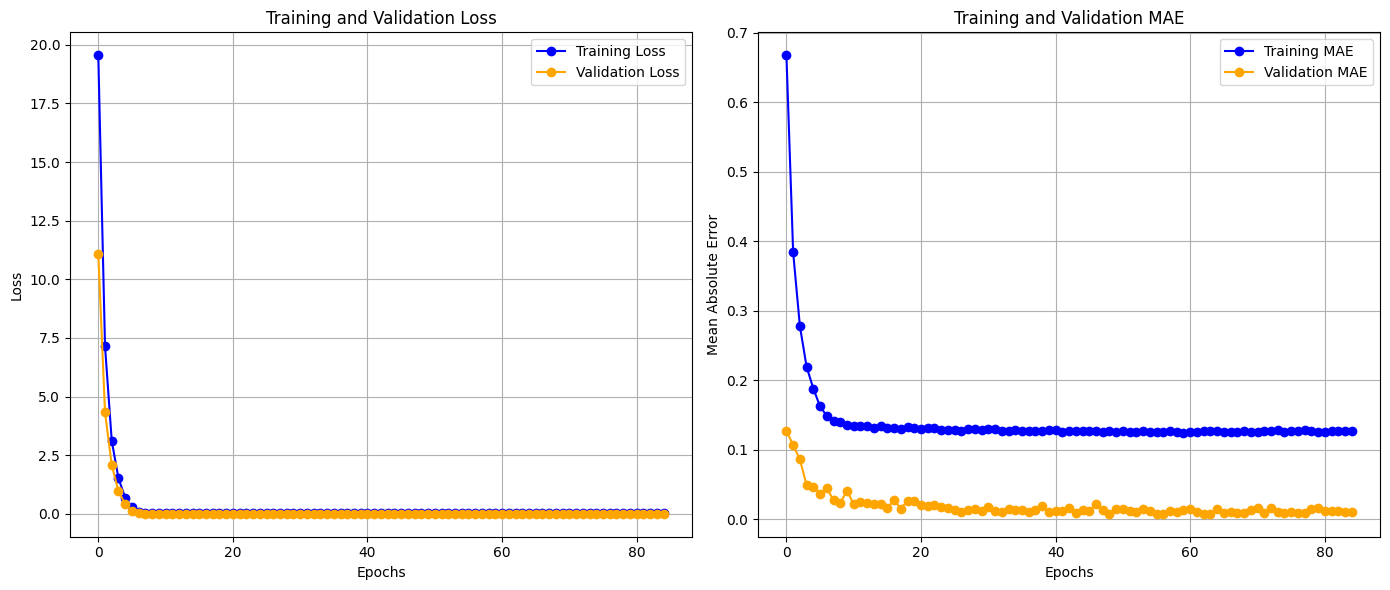

In [42]:
# Extract loss and metrics from history
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_mae = history.history['mae']
val_mae = history.history['val_mae']

# Reattempt plotting the learning curves side by side

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Training and Validation Loss Plot
axes[0].plot(train_loss, label='Training Loss', marker='o', color='blue')
axes[0].plot(val_loss, label='Validation Loss', marker='o', color='orange')
axes[0].set_title('Training and Validation Loss')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].grid(True)

# Training and Validation MAE Plot
axes[1].plot(train_mae, label='Training MAE', marker='o', color='blue')
axes[1].plot(val_mae, label='Validation MAE', marker='o', color='orange')
axes[1].set_title('Training and Validation MAE')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Mean Absolute Error')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()



In [43]:
y_test_scaled = target_scaler.transform(y_test)  # Apply scaling to y_test

NaN in y_test_scaled after fixing: False
1315/1315 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 7.5740e-04 - mae: 0.0084
Test Loss: 0.0008
Test MAE: 0.0084
1315/1315 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
NaN in predictions (y_pred): False
Predictions range (y_pred): [ 0.00292952  0.00148941  0.00043351 -0.0021373   0.00255765] [0.9984358  0.9975183  0.9970452  0.99538064 0.9969154 ]
Test targets range (y_test_original): [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 -2.77555756e-17
  0.00000000e+00] [1. 1. 1. 1. 1.]
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0024
R² Score: 0.9999


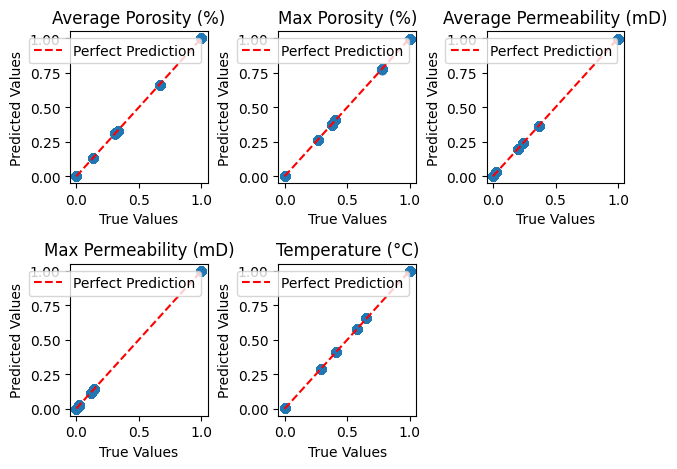

In [44]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score # Import mean_absolute_error

# Fix NaN values in y_test_scaled
y_test_scaled = np.nan_to_num(y_test_scaled, nan=np.nanmean(y_test_scaled, axis=0))
print("NaN in y_test_scaled after fixing:", np.isnan(y_test_scaled).any())

# Evaluate the model
test_loss, test_mae = model.evaluate(X_test_scaled, y_test_scaled, verbose=1)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test MAE: {test_mae:.4f}")

# Generate predictions
y_pred_scaled = model.predict(X_test_scaled)
y_pred = target_scaler.inverse_transform(y_pred_scaled)
y_test_original = target_scaler.inverse_transform(y_test_scaled)

# Verify predictions
print("NaN in predictions (y_pred):", np.isnan(y_pred).any())
print("Predictions range (y_pred):", y_pred.min(axis=0), y_pred.max(axis=0))
print("Test targets range (y_test_original):", y_test_original.min(axis=0), y_test_original.max(axis=0))

# Calculate metrics
mse = mean_squared_error(y_test_original, y_pred)
mae = mean_absolute_error(y_test_original, y_pred)
r2 = r2_score(y_test_original, y_pred)

print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R² Score: {r2:.4f}")
for i, target in enumerate(target_columns):
    plt.subplot(2, 3, i + 1)
    plt.scatter(y_test_original[:, i], y_pred[:, i], alpha=0.6)
    plt.title(target)
    plt.xlabel("True Values")
    plt.ylabel("Predicted Values")
    plt.plot(
        [y_test_original[:, i].min(), y_test_original[:, i].max()],
        [y_test_original[:, i].min(), y_test_original[:, i].max()],
        'r--', label="Perfect Prediction"
    )
    plt.legend()
plt.tight_layout()
plt.show()

In [46]:
print("Keys in imputed_data:", list(imputed_data.keys()))
print("Wells in final_combined_data:", final_combined_data["Well Name"].unique())
print("Wells in imputed_data.keys():", list(imputed_data.keys()))


Keys in imputed_data: ['REZOVACCKE_KRCCEVINE-1', 'REZOVACCKE_KRCCEVINE-2', 'SUHOPOLJE-1', 'VIROVITICA-1', 'VIROVITICA-3ALFA', 'LONCCARICA-1']
Wells in final_combined_data: ['LONCCARICA-1' 'REZOVACCKE_KRCCEVINE-1' 'REZOVACCKE_KRCCEVINE-2'
 'SUHOPOLJE-1' 'Unknown Well 1' 'Unknown Well 2' 'VIROVITICA-1'
 'VIROVITICA-3 ALFA' 'VIROVITICA-3ALFA']
Wells in imputed_data.keys(): ['REZOVACCKE_KRCCEVINE-1', 'REZOVACCKE_KRCCEVINE-2', 'SUHOPOLJE-1', 'VIROVITICA-1', 'VIROVITICA-3ALFA', 'LONCCARICA-1']


In [51]:
# Refit target_scaler if necessary
target_scaler.fit(y_train)


StandardScaler()

In [54]:
print("Sample y_train before scaling:")
print(y_train.head())

print("Sample y_train after scaling:")
print(target_scaler.transform(y_train)[:5])


Sample y_train before scaling:
        Average Porosity (%)  Max Porosity (%)  Average Permeability (mD)  \
151209              0.666667          0.781250                   0.199145   
68771               0.000000          0.265625                   0.000000   
113687              0.133333          0.000000                   0.367521   
6721                1.000000          1.000000                   1.000000   
106246              0.133333          0.000000                   0.367521   

        Max Permeability (mD)  Temperature (°C)  
151209               0.024142          0.290323  
68771                0.000000          0.653226  
113687               0.114358          1.000000  
6721                 1.000000          0.000000  
106246               0.114358          1.000000  
Sample y_train after scaling:
[[ 1.22320081  1.35179262 -0.15535715 -0.43911197 -0.98270793]
 [-1.07327578 -0.37661063 -0.90342546 -0.53087102  0.26355136]
 [-0.61398047 -1.26700019  0.4771298  -0.09622289 

In [55]:
# Debug: Verify unknown wells
print("Unknown wells shape after standardization:", unknown_wells.shape)
if unknown_wells.empty:
    print("No unknown wells identified after standardization. Exiting...")
    exit()

# Step 1: Align unknown wells with training features
X_unknown_aligned = pd.DataFrame(columns=X_train.columns)
for feature in X_train.columns:
    if feature in unknown_wells.columns:
        X_unknown_aligned[feature] = unknown_wells[feature]
    else:
        X_unknown_aligned[feature] = X_train[feature].mean()  # Fill missing features with training mean

# Debug: Check alignment
print("Aligned unknown wells data shape:", X_unknown_aligned.shape)

# Step 2: Handle missing values in unknown data
X_unknown_aligned = X_unknown_aligned.fillna(X_train.mean())
print("Fixed missing values in `X_unknown_aligned`:", X_unknown_aligned.isna().sum().sum())

# Step 3: Scale unknown data
X_unknown_scaled = scaler.transform(X_unknown_aligned)
print("Scaled data for unknown wells (X_unknown_scaled):")
print(X_unknown_scaled)

# Step 4: Predict properties
y_unknown_pred_scaled = model.predict(X_unknown_scaled)
print("Scaled predictions for unknown wells (y_unknown_pred_scaled):")
print(y_unknown_pred_scaled)

# Step 5: Denormalize predictions
# Ensure the target scaler is properly fitted
target_scaler.fit(y_train)  # Fit using original training target data
y_unknown_pred = target_scaler.inverse_transform(y_unknown_pred_scaled)

# Step 6: Format predictions into a DataFrame
predicted_columns = [
    "Average Porosity (%)", "Max Porosity (%)",
    "Average Permeability (mD)", "Max Permeability (mD)", "Temperature (°C)"
]
predicted_unknowns = pd.DataFrame(y_unknown_pred, columns=predicted_columns)
predicted_unknowns["Well Name"] = unknown_wells["Well Name"].values

# Debug: Predictions
print("Predictions for unknown wells:")
print(predicted_unknowns)

# Step 7: Save predictions
predicted_unknowns.to_csv("predicted_unknown_wells.csv", index=False)
print("Predicted results saved to 'predicted_unknown_wells.csv'.")


Unknown wells shape after standardization: (2, 32)
Aligned unknown wells data shape: (2, 17)
Fixed missing values in `X_unknown_aligned`: 0
Scaled data for unknown wells (X_unknown_scaled):
[[ 0.          0.          0.          0.          0.          0.
   0.          0.         -1.61547686 -0.27282369 -1.94692197  0.
   0.22806095  0.2449162   0.11272742  0.23942206 -0.08955544]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.86437195 -0.32521726  1.61823214  0.
   0.22806095  0.2449162   0.11272742  0.23942206 -0.08955544]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Scaled predictions for unknown wells (y_unknown_pred_scaled):
[[ 1.0353332   1.0813798   0.39784428  0.41252878 -0.9430774 ]
 [-0.05517802 -0.16499636  0.08877807  0.02450583  0.16934581]]
Predictions for unknown wells:
   Average Porosity (%)  Max Porosity (%)  Average Permeability (mD)  \
0              0.612129          0.700579                   0.346415   
1              0.

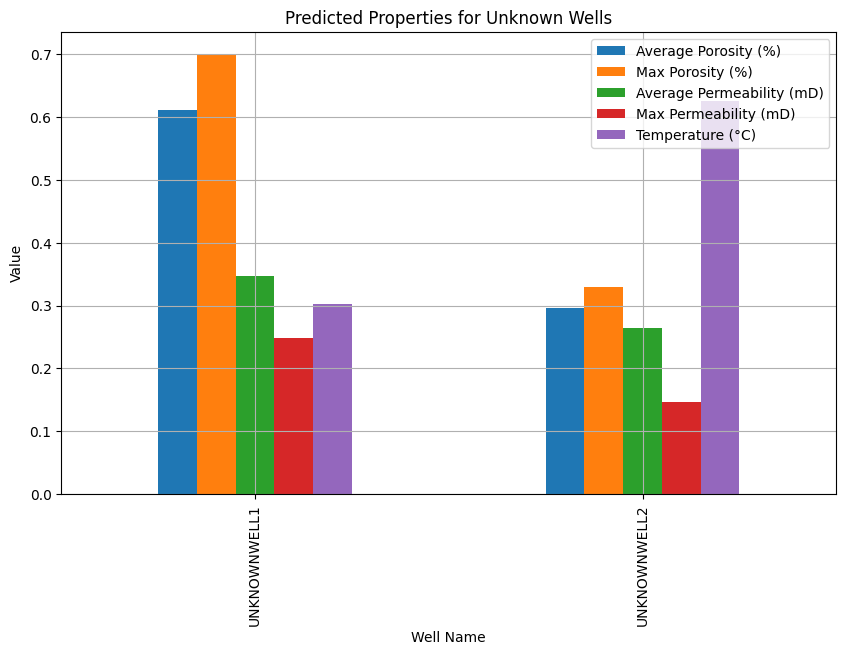

In [56]:
# Plot predicted values for unknown wells
predicted_unknowns.set_index("Well Name")[predicted_columns].plot(kind="bar", figsize=(10, 6))
plt.title("Predicted Properties for Unknown Wells")
plt.ylabel("Value")
plt.xlabel("Well Name")
plt.legend(loc="upper right")
plt.grid(True)
plt.show()
